In [1]:
# imported necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn import model_selection
#from sklearn import cross_validation
from scipy.stats import uniform

In [2]:
warnings.filterwarnings("ignore")

In [3]:
import sqlite3
con = sqlite3.connect("final.sqlite")

In [4]:
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [5]:
cleaned_data.shape

(364171, 12)

In [7]:
# Sort data based on time
cleaned_data["Time"] = pd.to_datetime(cleaned_data["Time"], unit = "s")
cleaned_data = cleaned_data.sort_values(by = "Time")
cleaned_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [8]:
cleaned_data.shape

(364171, 12)

In [9]:
cleaned_data["Score"].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [10]:
final_100k = cleaned_data.iloc[:100000,:]

In [11]:
final_100k.shape

(100000, 12)

In [14]:
# converting scores in 0 and 1
final_100k["Score"] = final_100k["Score"].map(lambda x: 1 if x == "positive" else 0)
#encoded_labels = df['label'].map(lambda x: 1 if x == 'spam' else 0).values

# Bag of Word

In [16]:
# Grid search
def lr_grid_plot(X_train, y_train):
    tuned_parameters_grid = [{'penalty': ['l1','l2'], 'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
    cv = TimeSeriesSplit(n_splits = 3)
    model_lr_grid = GridSearchCV(LogisticRegression(), param_grid = tuned_parameters_grid, cv = cv)
    model_lr_grid.fit(X_train, y_train)
    print("\n**********GridSearchCV**********\n")
    print("\nOptimal C:", model_lr_grid.best_estimator_.C)
    print('\nBest penalty:', model_lr_grid.best_estimator_.get_params()['penalty'])
    score = model_lr_grid.cv_results_
    plot_df = pd.DataFrame(score)
    plt.plot(plot_df["param_C"], 1- plot_df["mean_test_score"], "-o")
    plt.title("CV Error vs C")
    plt.xlabel("C")
    plt.ylabel("Cross-validation Error")
    plt.show()
    return model_lr_grid.best_estimator_.C

In [17]:
# Random search
def lr_random_plot(X_train, y_train):
    tuned_parameters_random = {'penalty': ['l1','l2'], 'C': uniform(loc = 0, scale = 4)}
    cv = TimeSeriesSplit(n_splits = 3)
    model_lr_random = RandomizedSearchCV(LogisticRegression(), tuned_parameters_random, cv = cv, n_iter = 10)
    model_lr_random.fit(X_train, y_train)
    print("\n\n**********RandomizedSearchCV**********\n")
    print("\nOptimal C:", model_lr_random.best_estimator_.C)
    print('\nBest penalty:', model_lr_random.best_estimator_.get_params()['penalty'])
    score = model_lr_random.cv_results_
    plot_df = pd.DataFrame(score)
    plt.plot(plot_df["param_C"], 1 - plot_df["mean_test_score"], "-o")
    plt.title("CV Error vs C")
    plt.xlabel("C")
    plt.ylabel("Cross-validation Error")
    plt.show()
    return model_lr_random.best_estimator_.C

In [18]:
def plot_precision_recall_curve(recall, precision):
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision_recall_curve")
    plt.plot(recall, precision, "-o")
    plt.show()

In [19]:
# 100k data which will use to train model after vectorization
X = final_100k["CleanedText"]
print("shape of X:", X.shape)

shape of X: (100000,)


In [20]:
# class label
y = final_100k["Score"]
print("shape of y:", y.shape)

shape of y: (100000,)


In [21]:
# split data into train and test where 70% data used to train model and 30% for test
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, y_train.shape, x_test.shape)

(70000,) (70000,) (30000,)


In [22]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 
bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<70000x31373 sparse matrix of type '<class 'numpy.int64'>'
	with 2094656 stored elements in Compressed Sparse Row format>

In [23]:
# Standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)

In [24]:
# Test Vectorizor
x_test = bow.transform(x_test)
x_test.shape

(30000, 31373)

In [25]:
scaler = StandardScaler(with_mean = False)
std_x_test = scaler.fit_transform(x_test)

In [26]:
std_x_test.shape

(30000, 31373)


**********GridSearchCV**********


Optimal C: 0.01

Best penalty: l2


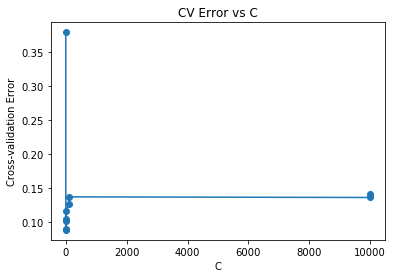

0.01

In [27]:
# To choose optimal c using cross validation
from sklearn.model_selection import TimeSeriesSplit
optimal_lambda_bow_grid = lr_grid_plot(std_X_train, y_train)
optimal_lambda_bow_grid

As we can see in the error vs c graph, when c value is increasing, error is slightly increasing and at 0.01(not cristal clear in the plotted graph because we are increasing c value exponentialy) error is less.

In [28]:
# instantiate learning model 
lr_model =  LogisticRegression(penalty = 'l2', C = optimal_lambda_bow_grid, class_weight = "balanced")
# fitting the model
lr_model.fit(std_X_train, y_train)
# predict the response
pred = lr_model.predict(std_x_test)
# predict probablistic response
pred_prob = lr_model.predict_proba(std_x_test)

Average precision score: 0.9690376273112409
F1_score: 0.9312872104218654
Auc score: 0.9690916270782933


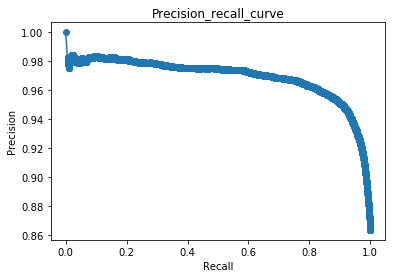

In [29]:
# F1-score, auc, precision_recall_curve
from sklearn.metrics import f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
f1 = f1_score(y_test, pred)
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob[:,1])
auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, pred_prob[:,1])
print("Average precision score:", avg_precision)
print("F1_score:", f1)
print("Auc score:",auc)
plot_precision_recall_curve(recall, precision)

In [30]:
train_acc_bow_grid = lr_model.score(std_X_train, y_train)
print("Train accuracy:",train_acc_bow_grid)

Train accuracy: 0.9710142857142857


In [31]:
test_acc_bow_grid = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' % (optimal_lambda_bow_grid, test_acc_bow_grid))


The accuracy of the logistic regression for c = 0.010000 is 88.34%


In [32]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 2805,  1298],
       [ 2199, 23698]], dtype=int64)

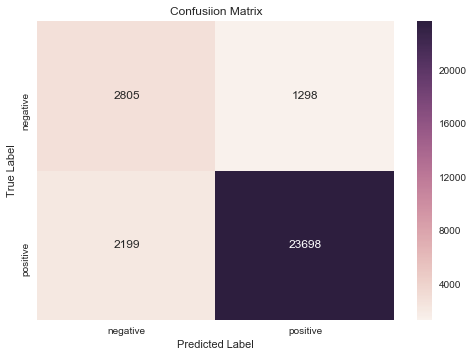

In [33]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [34]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.56      0.68      0.62      4103
           1       0.95      0.92      0.93     25897

   micro avg       0.88      0.88      0.88     30000
   macro avg       0.75      0.80      0.77     30000
weighted avg       0.90      0.88      0.89     30000





**********RandomizedSearchCV**********


Optimal C: 0.8942617375947473

Best penalty: l1


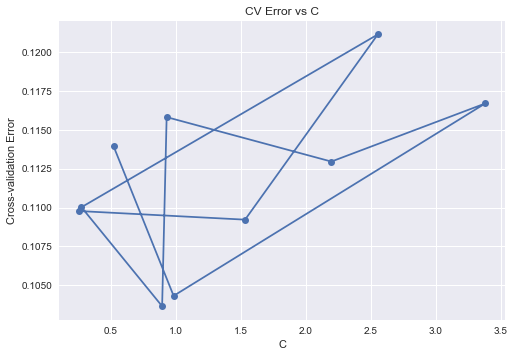

0.8942617375947473

In [35]:
optimal_lambda_bow_random = lr_random_plot(std_X_train, y_train)
optimal_lambda_bow_random

We can see in random search, c value choosen randomly and we plotted error on randomly choosen each c value. As it does not make much more sense but can give some intution to uninformed person.

In [36]:
# instantiate learning model 
lr_model =  LogisticRegression(penalty = 'l1', C = optimal_lambda_bow_random, class_weight = "balanced")
# fitting the model
lr_model.fit(std_X_train, y_train)
# predict the response
pred = lr_model.predict(std_x_test)
# predict probablistic response
pred_prob = lr_model.predict_proba(std_x_test)

As we know it is imbalanced data, so we should not use accuracy to evaluate our classifier beacause it apply a naive(0.5) threshold to decide b/w classes and it is usually wrong when we are dealing with imbalanced data. We used class_weight = "balanced" which will implicitly balance the minority class. this can be thought as oversampling. The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. <br>
https://stackoverflow.com/questions/30972029/how-does-the-class-weight-parameter-in-scikit-learn-work <br>
https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/class_weight.py <br>
https://github.com/scikit-learn/scikit-learn/issues/4324

Average precision score: 0.9578121261574786
F1_score: 0.9232038015198226
Auc score: 0.9590816825513797


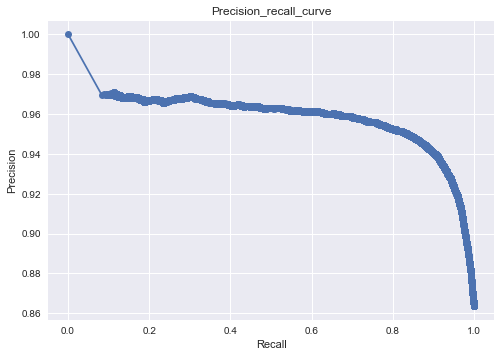

In [37]:
# F1-score, auc, precision_recall_curve
from sklearn.metrics import f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
f1 = f1_score(y_test, pred)
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob[:,1])
auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, pred_prob[:,1])
print("Average precision score:", avg_precision)
print("F1_score:", f1)
print("Auc score:",auc)
plot_precision_recall_curve(recall, precision)

We used F1-score(2*(precision * recall)/(precision + recall)) which is a good performence measure and usually recommended when dealing with imbalanced data. A good F1 score for class +ve(1) is closer to 1. Here, F1-score is 92 which shows a good results.

In [38]:
train_acc_bow_random = lr_model.score(std_X_train, y_train)
print("Train accuracy:",train_acc_bow_random)

Train accuracy: 0.9786571428571429


In [39]:
test_acc_bow_random = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' % (optimal_lambda_bow_random, test_acc_bow_random))


The accuracy of the logistic regression for c = 0.894262 is 86.96%


In [40]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 2581,  1522],
       [ 2389, 23508]], dtype=int64)

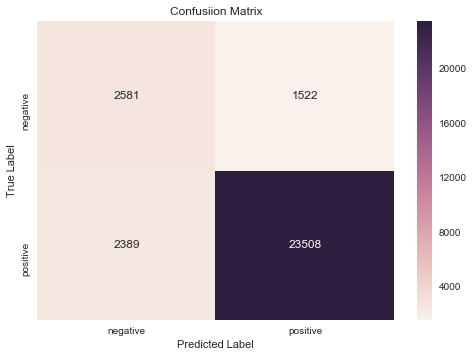

In [41]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [42]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.52      0.63      0.57      4103
           1       0.94      0.91      0.92     25897

   micro avg       0.87      0.87      0.87     30000
   macro avg       0.73      0.77      0.75     30000
weighted avg       0.88      0.87      0.87     30000



In [43]:
# Tried different value of c and finding features weight
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C)
C_param = [10, 1, 0.1]

for c in C_param:
    clf = LogisticRegression(penalty='l1', C = c, class_weight = "balanced")
    clf.fit(X_train, y_train)
    print('\nC value:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy: %0.2f%%' %(clf.score(std_X_train, y_train) * 100))
    print('Test accuracy: %0.2f%%' %(clf.score(std_x_test, y_test) * 100))
    print("Number of non-zero element: ",np.count_nonzero(clf.coef_))


C value: 10
Coefficient of each feature: [[0. 0. 0. ... 0. 0. 0.]]
Training accuracy: 83.63%
Test accuracy: 76.62%
Number of non-zero element:  9547

C value: 1
Coefficient of each feature: [[0. 0. 0. ... 0. 0. 0.]]
Training accuracy: 81.61%
Test accuracy: 77.92%
Number of non-zero element:  4933

C value: 0.1
Coefficient of each feature: [[0. 0. 0. ... 0. 0. 0.]]
Training accuracy: 81.21%
Test accuracy: 80.61%
Number of non-zero element:  1252


## Checking for multicollinearity using pertubation test

In [44]:
clf = LogisticRegression(penalty='l1', C = optimal_lambda_bow_random, class_weight = "balanced")
clf.fit(std_X_train, y_train)
y_pred = clf.predict(std_x_test)
print("Accuracy score: %0.2f%%" %(accuracy_score(y_test, y_pred) * 100))
print(np.count_nonzero(clf.coef_))

Accuracy score: 86.95%
12290


In [45]:
std_X_train.shape

(70000, 31373)

In [46]:
from scipy.sparse import find

# Before adding noise in data
cf = clf.coef_[0]
w_coef1 = cf[np.nonzero(cf)]
print(w_coef1[:20])

[ 0.00700233  0.05341299  0.0413039  -0.07670476  0.01054967 -0.04019997
  0.00649232  0.0359533   0.06503626 -0.04407528  0.07602213  0.1576802
 -0.00018427 -0.06443075 -0.05869084  0.00484927  0.03611886 -0.05202776
  0.09810958  0.01428477]


In [47]:
# Generate random normal variable as a noise 
std_X_train_pert = std_X_train
noise = np.random.normal(0, 0.0001, size = (std_X_train_pert[np.nonzero(std_X_train_pert)].size))
#print(noise.shape)
np.nonzero(std_X_train_pert)
std_X_train_pert[np.nonzero(std_X_train_pert)] = noise + std_X_train_pert[np.nonzero(std_X_train_pert)]
std_X_train_pert.shape

(70000, 31373)

In [48]:
clf = LogisticRegression(penalty ='l1', C = optimal_lambda_bow_random, class_weight = "balanced")
clf.fit(std_X_train_pert, y_train)
y_pred = clf.predict(std_x_test)
print("Accuracy score: %0.2f%%" %(accuracy_score(y_test, y_pred) * 100))
print(np.count_nonzero(clf.coef_))

Accuracy score: 86.96%
12306


In [49]:
cf = clf.coef_[0]
w_coef2 = cf[np.nonzero(cf)]
print(w_coef2[:20])

[ 0.00696214  0.07343338  0.04132438 -0.07670086  0.01054026 -0.04047809
  0.00664749  0.03592013  0.06504404 -0.04409145  0.07600065  0.15774789
 -0.00038678 -0.06475417 -0.05871674  0.00489932  0.03615079 -0.0521023
  0.09826597  0.01423373]


In [50]:
# Calculate %increase 
cnt = 0
for w1, w2 in zip(w_coef1, w_coef2):
    inc = abs(w1 - w2)/abs(w1) * 100
    if inc > 40:
        cnt += 1
print("No of weights that changes more than 40% is:", cnt)

No of weights that changes more than 40% is: 9962


In [51]:
# Features importance 

features = bow.get_feature_names()
coef = clf.coef_[0]
coeff_df = pd.DataFrame({'Word' : features, 'Coefficient' : coef})
coeff_df = coeff_df.sort_values("Coefficient", ascending = False)
print('*****Top 10 positive*****')
print(coeff_df.head(10))
print('*****Top 10 negative*****')
print(coeff_df.tail(10))

*****Top 10 positive*****
       Coefficient     Word
11844     1.673659    great
17684     1.517309     mole
2500      1.514809     best
16701     1.455165   marmit
16124     1.415644     love
20395     1.197361  perfect
20871     1.122769    plaqu
267       1.074002   addict
24982     1.004697  skeptic
11567     0.996651     good
*****Top 10 negative*****
       Coefficient        Word
4036     -0.588534      canida
13968    -0.602908   insuffici
20637    -0.610868   physiolog
10515    -0.612701    fragment
23302    -0.620950       river
26235    -0.626423       stool
7708     -0.629867  disappoint
30898    -0.747167         www
5272     -0.830706     clasico
30802    -1.049499       worst


**Terminology**<br>

**true positives (TP):** We predicted +ve review, and review is also +ve.<br>
**true negatives (TN):** We predicted -ve, and review is also -ve.<br>
**false positives (FP):** We predicted +ve, but the review is not actually +ve.(Also known as a "Type I error.")<br>
**false negatives (FN):** We predicted -ve, but the review is actually +ve.(Also known as a "Type II error.")<br>


**Observations**</br>
1. When we applied logistic regression on bow featurization using grid search and random search it does perform well in both cases but comparison to random search, grid search accuracy is quite high.
2. F1-score is good in grid search comparison to random search which shows that classifier is working good.
3. We have also seen that as we are decreasing the value of c we are getting more sparse solution i.e. the less important features becomes zero. which can be help to designing a low latency system.
4. In a nutshell we can say the generalization error is low means this model works quite well with unseen data.
5. Features are collinear so we can not use feature importance without removing collinear features.

# Tf-Idf

In [52]:
# data
X = final_100k["CleanedText"]

In [53]:
# Target/class-label
y = final_100k["Score"]

In [54]:
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(70000,) (30000,) (70000,) (30000,)


In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)
X_trn = X_train
X_train

<70000x918966 sparse matrix of type '<class 'numpy.float64'>'
	with 4504849 stored elements in Compressed Sparse Row format>

In [56]:
# Standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)

In [57]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
x_tst = x_test
x_test.shape

(30000, 918966)

In [58]:
scaler = StandardScaler(with_mean = False)
std_x_test = scaler.fit_transform(x_test)


**********GridSearchCV**********


Optimal C: 0.01

Best penalty: l1


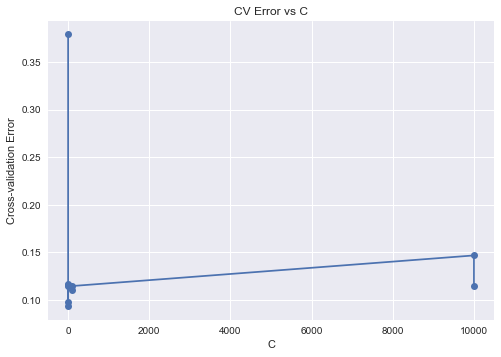

0.01

In [59]:
# To choose optimal_alpha using nested cross validation
optimal_lambda_tfidf_grid = lr_grid_plot(std_X_train, y_train)
optimal_lambda_tfidf_grid

In [60]:
# instantiate learning model 
lr_model =  LogisticRegression(penalty = 'l1', C = optimal_lambda_tfidf_grid, class_weight = "balanced")
# fitting the model
lr_model.fit(std_X_train, y_train)
# predict the response
pred = lr_model.predict(std_x_test)
# predict probablistic response
pred_prob = lr_model.predict_proba(std_x_test)

Average precision score: 0.9880400154093555
F1_score: 0.9525905408738213
Auc score: 0.9880398511208974


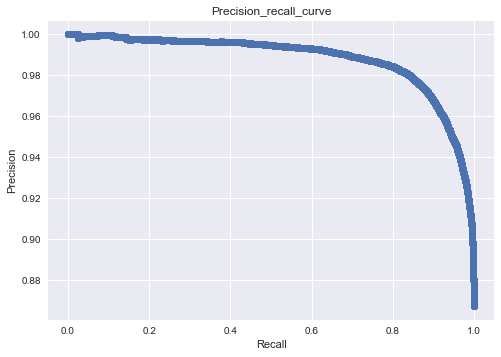

In [61]:
# F1-score, auc, precision_recall_curve
from sklearn.metrics import f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
f1 = f1_score(y_test, pred)
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob[:,1])
auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, pred_prob[:,1])
print("Average precision score:", avg_precision)
print("F1_score:", f1)
print("Auc score:",auc)
plot_precision_recall_curve(recall, precision)

In [62]:
train_acc_tfidf_grid = lr_model.score(std_X_train, y_train)
print("Train accuracy %f%%:" % (train_acc_tfidf_grid))

Train accuracy 0.987700%:


In [63]:
test_acc_tfidf_grid = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' % (optimal_lambda_tfidf_grid, test_acc_tfidf_grid))


The accuracy of the logistic regression for c = 0.010000 is 91.67%


In [64]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 2395,  1708],
       [  791, 25106]], dtype=int64)

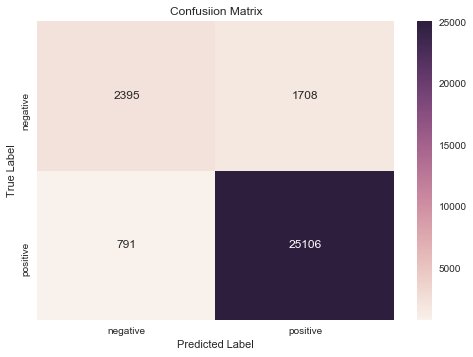

In [65]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [66]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.75      0.58      0.66      4103
           1       0.94      0.97      0.95     25897

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.84      0.78      0.80     30000
weighted avg       0.91      0.92      0.91     30000





**********RandomizedSearchCV**********


Optimal C: 0.23860360422442373

Best penalty: l1


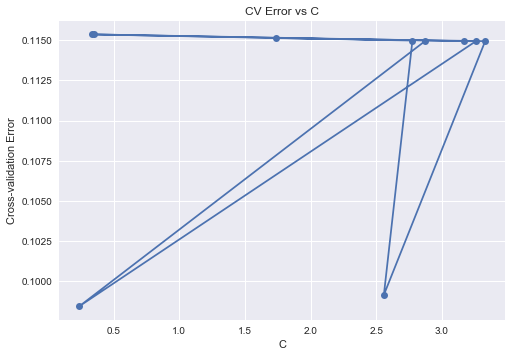

0.23860360422442373

In [67]:
optimal_lambda_tfidf_random = lr_random_plot(std_X_train, y_train)
optimal_lambda_tfidf_random

In [68]:
# instantiate learning model 
lr_model =  LogisticRegression(penalty = 'l1', C = optimal_lambda_tfidf_random, class_weight = "balanced")
# fitting the model
lr_model.fit(std_X_train, y_train)
# predict the response
pred = lr_model.predict(std_x_test)
# predict probablistic response
pred_prob = lr_model.predict_proba(std_x_test)

Average precision score: 0.9876647243700902
F1_score: 0.9504262000897263
Auc score: 0.9876644215579895


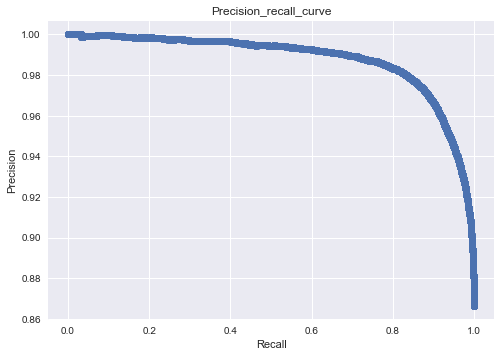

In [69]:
# F1-score, auc, precision_recall_curve
from sklearn.metrics import f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
f1 = f1_score(y_test, pred)
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob[:,1])
auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, pred_prob[:,1])
print("Average precision score:", avg_precision)
print("F1_score:", f1)
print("Auc score:",auc)
plot_precision_recall_curve(recall, precision)

In [70]:
train_acc_tfidf_random = lr_model.score(std_X_train, y_train)
print("Training accuracy:", train_acc_tfidf_random)

Training accuracy: 0.9999857142857143


In [71]:
test_acc_tfidf_random = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' % (optimal_lambda_tfidf_random, test_acc_tfidf_random))


The accuracy of the logistic regression for c = 0.238604 is 91.16%


In [72]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 1926,  2177],
       [  475, 25422]], dtype=int64)

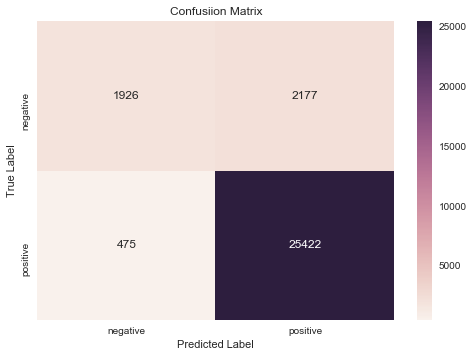

In [73]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [74]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.47      0.59      4103
           1       0.92      0.98      0.95     25897

   micro avg       0.91      0.91      0.91     30000
   macro avg       0.86      0.73      0.77     30000
weighted avg       0.90      0.91      0.90     30000



In [75]:
# Tried different value of c and finding features weight
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C)
C_param = [10, 1, 0.1]

for c in C_param:
    clf = LogisticRegression(penalty = 'l1', C = c, class_weight = "balanced")
    clf.fit(X_train, y_train)
    print('\nC value:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy: %0.3f%%' %(clf.score(std_X_train, y_train) * 100))
    print('Test accuracy: %0.3f%%' %(clf.score(std_x_test, y_test) * 100))
    print("Number of non-zero element: ",np.count_nonzero(clf.coef_))


C value: 10
Coefficient of each feature: [[0. 0. 0. ... 0. 0. 0.]]
Training accuracy: 78.476%
Test accuracy: 74.343%
Number of non-zero element:  10367

C value: 1
Coefficient of each feature: [[0. 0. 0. ... 0. 0. 0.]]
Training accuracy: 85.226%
Test accuracy: 84.003%
Number of non-zero element:  1903

C value: 0.1
Coefficient of each feature: [[0. 0. 0. ... 0. 0. 0.]]
Training accuracy: 84.727%
Test accuracy: 84.987%
Number of non-zero element:  194


## Checking for multicollinearity using pertubation test

In [76]:
clf = LogisticRegression(penalty = 'l1', C = optimal_lambda_tfidf_grid, class_weight = "balanced")
clf.fit(std_X_train, y_train)
y_pred = clf.predict(std_x_test)
print("Accuracy score: %.2f%%" %(accuracy_score(y_test, y_pred) * 100))
print(np.count_nonzero(clf.coef_))

Accuracy score: 91.67%
25941


In [77]:
std_X_train.shape

(70000, 918966)

In [78]:
np.count_nonzero(clf.coef_)

25941

In [79]:
from scipy.sparse import find

# Before adding noise in data
cf = clf.coef_[0]
w_coef1 = cf[np.nonzero(cf)]
print(w_coef1[:20])

[-5.34660837e-03  2.69829787e-07 -1.12502174e-02 -3.20388213e-03
 -4.90267228e-06 -1.29518304e-03 -9.83575170e-03 -8.51583103e-03
 -3.38161558e-04  1.98212291e-03 -1.90405815e-05 -4.84107706e-03
 -9.56830670e-03 -1.63089828e-03 -6.50705239e-03 -6.44125436e-03
 -1.86941731e-04  6.48846600e-05 -2.25836974e-04 -7.67439650e-03]


In [80]:
# Generate random normal variable as a noise 
std_X_train_pert = std_X_train
noise = np.random.normal(0, 0.001, size = (std_X_train_pert[np.nonzero(std_X_train_pert)].size,))
#print(noise.shape)
np.nonzero(std_X_train_pert)
std_X_train_pert[np.nonzero(std_X_train_pert)] = noise + std_X_train_pert[np.nonzero(std_X_train_pert)]
std_X_train_pert.shape

(70000, 918966)

In [81]:
std_X_train_pert.shape

(70000, 918966)

In [82]:
clf = LogisticRegression(penalty = 'l1', C = optimal_lambda_tfidf_grid, class_weight = "balanced")
clf.fit(std_X_train_pert, y_train)
y_pred = clf.predict(std_x_test)
print("Accuracy score: %0.2f%%" %(accuracy_score(y_test, y_pred) * 100))
print(np.count_nonzero(clf.coef_))

Accuracy score: 91.64%
28254


In [83]:
np.count_nonzero(clf.coef_)

28254

In [84]:
cf = clf.coef_[0]
w_coef2 = cf[np.nonzero(cf)]
print(w_coef2[:20])

[-1.30268616e-04  3.52547637e-07 -9.29511052e-03 -2.05167273e-03
 -8.87310611e-09 -1.87409099e-03 -1.20495067e-02 -8.53370230e-03
 -6.84051111e-03  4.13605668e-05 -6.97507090e-03 -4.86942851e-03
 -8.01845737e-03 -3.30710756e-03 -4.86304712e-03 -6.43382539e-03
 -1.55072671e-04  5.99775078e-04  2.02746598e-04 -5.75468749e-05]


In [85]:
# Calculate %increase 
cnt = 0
for w1, w2 in zip(w_coef1, w_coef2):
    inc = abs(w1 - w2)/abs(w1) * 100
    if inc > 40:
        cnt += 1
print("No of weights that changes more than 40% is:", cnt)

No of weights that changes more than 40% is: 23929


In [86]:
# Features importance 

features = tf_idf_vect.get_feature_names()
coef = clf.coef_[0]
coeff_df = pd.DataFrame({'Word' : features, 'Coefficient' : coef})
coeff_df = coeff_df.sort_values('Coefficient', ascending = 0)
print('*****Top 10 positive*****')
print(coeff_df.head(10))
print('*****Top 10 negative*****')
print(coeff_df.tail(10))

*****Top 10 positive*****
        Coefficient            Word
358511     0.776070           great
71220      0.566746            best
474782     0.554996            love
213270     0.426021          delici
591227     0.367895         perfect
349213     0.363999            good
275318     0.323315           excel
386042     0.271762  high recommend
292349     0.262710         favorit
900387     0.235251          wonder
*****Top 10 negative*****
        Coefficient        Word
881131    -0.147959  wast money
82185     -0.149272       bland
757891    -0.162521       stale
671250    -0.169277      return
392701    -0.172289     horribl
822911    -0.174585       threw
48095     -0.191153          aw
809738    -0.219280     terribl
905416    -0.259510       worst
227960    -0.361474  disappoint


**Observations**
1. As we are getting train_accuracy 99% and test_accuray 91% means train_accuracy is higher that test_accuracy. It can be possible due to low sample size, noise in data etc and as we know cross-validation does not completly remove overfitting but can give the best possible accuracy.
2. When we are increasing value of c, sparsity is incresing means the less important features becomes zero. 
3. In a nutshell we can say this model works well with unseen data and also have high accuracy than bow representation.
4. We check for multicollinearity using pertubation test and found that more than 80% of features weight changes more than 40% so features are collinear and hence we can not use feauture importance for interpretation.

# Word2vec

In [87]:
# data
X = final_100k["Text"]
X.shape

(100000,)

In [88]:
# Target/class-label
y = final_100k["Score"]
y.shape

(100000,)

In [89]:
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(70000,) (30000,) (70000,) (30000,)


In [90]:
import re
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [91]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [92]:
w2v_model_train = gensim.models.Word2Vec(list_of_sent, min_count = 5, size = 50, workers = 4)

In [93]:
w2v_model_train.wv.most_similar('like')

[('prefer', 0.644690752029419),
 ('think', 0.6248317956924438),
 ('mean', 0.6054805517196655),
 ('crave', 0.590172529220581),
 ('awful', 0.5754127502441406),
 ('expect', 0.5612983703613281),
 ('enjoy', 0.5505330562591553),
 ('love', 0.5446635484695435),
 ('gross', 0.5442739725112915),
 ('miss', 0.544153094291687)]

In [94]:
w2v_train = w2v_model_train[w2v_model_train.wv.vocab]

In [95]:
w2v_train.shape

(16156, 50)

In [96]:
# Train your own Word2Vec model using your own test text corpus
import gensim
list_of_sent_test = []
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [97]:
w2v_model_test = gensim.models.Word2Vec(list_of_sent_test, min_count = 5, size = 50, workers = 4)

In [98]:
w2v_model_test.wv.most_similar('like')

[('prefer', 0.6483543515205383),
 ('mean', 0.5963467359542847),
 ('think', 0.5807939767837524),
 ('dislike', 0.5591044425964355),
 ('fine', 0.5556191205978394),
 ('know', 0.5516791939735413),
 ('expect', 0.545376181602478),
 ('okay', 0.5443829894065857),
 ('miss', 0.5438836812973022),
 ('enjoy', 0.5287797451019287)]

In [99]:
w2v_test = w2v_model_test[w2v_model_test.wv.vocab]

In [100]:
w2v_test.shape

(10801, 50)

# Average word2vec

In [101]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

70000
50


In [102]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
50


In [103]:
X_train = sent_vectors
#X_train

In [104]:
# Standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)

In [105]:
x_test = sent_vectors_test
#x_test

In [106]:
scaler = StandardScaler(with_mean = False)
std_x_test = scaler.fit_transform(x_test)


**********GridSearchCV**********


Optimal C: 100

Best penalty: l2


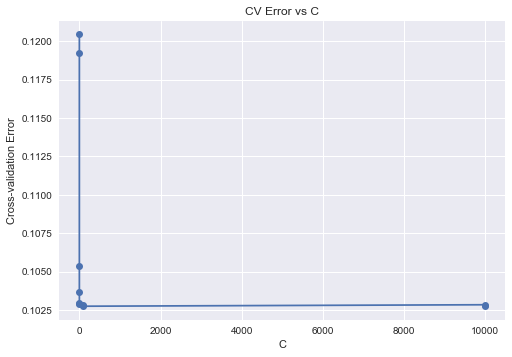

100

In [107]:
# To choose optimal_alpha using nested cross validation
#from sklearn.model_selection import KFold
#from sklearn.model_selection import KFold
optimal_lambda_avgw2v_grid = lr_grid_plot(std_X_train, y_train)
optimal_lambda_avgw2v_grid

In [108]:
# instantiate learning model 
lr_model =  LogisticRegression(penalty = 'l1', C = optimal_lambda_avgw2v_grid, class_weight = "balanced")
# fitting the model
lr_model.fit(std_X_train, y_train)
# predict the response
pred = lr_model.predict(std_x_test)
# predict probablistic response
pred_prob = lr_model.predict_proba(std_x_test)

Average precision score: 0.9378615600812116
F1_score: 0.92657793044225
Auc score: 0.9378585392667066


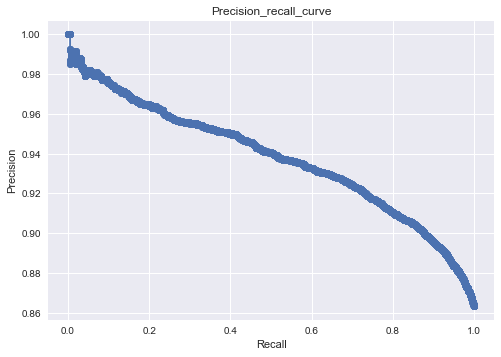

In [109]:
# F1-score, auc, precision_recall_curve
from sklearn.metrics import f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
f1 = f1_score(y_test, pred)
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob[:,1])
auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, pred_prob[:,1])
print("Average precision score:", avg_precision)
print("F1_score:", f1)
print("Auc score:",auc)
plot_precision_recall_curve(recall, precision)

In [110]:
train_acc_avgw2v_grid = lr_model.score(std_X_train, y_train)
print("Train accuracy:", train_acc_avgw2v_grid)

Train accuracy: 0.7982571428571429


In [111]:
test_acc_avgw2v_grid = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' % (optimal_lambda_avgw2v_grid, test_acc_avgw2v_grid))


The accuracy of the logistic regression for c = 100.000000 is 86.32%


In [112]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[    0,  4103],
       [    1, 25896]], dtype=int64)

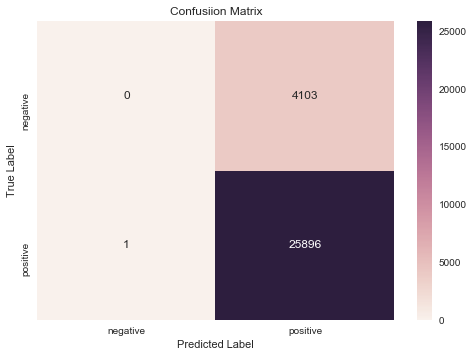

In [113]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [114]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4103
           1       0.86      1.00      0.93     25897

   micro avg       0.86      0.86      0.86     30000
   macro avg       0.43      0.50      0.46     30000
weighted avg       0.75      0.86      0.80     30000





**********RandomizedSearchCV**********


Optimal C: 3.3331862167206348

Best penalty: l2


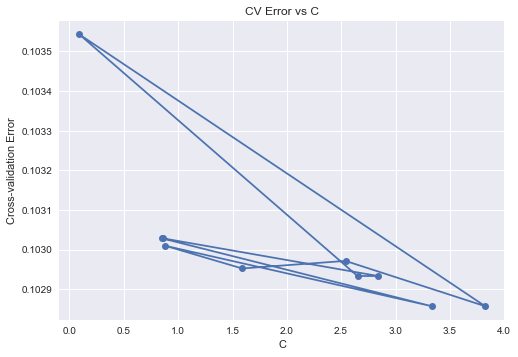

3.3331862167206348

In [115]:
optimal_lambda_avgw2v_random = lr_random_plot(std_X_train, y_train)
optimal_lambda_avgw2v_random

In [116]:
# instantiate learning model 
lr_model =  LogisticRegression(penalty = 'l1', C = optimal_lambda_avgw2v_random, class_weight = "balanced")
# fitting the model
lr_model.fit(std_X_train, y_train)
# predict the response
pred = lr_model.predict(std_x_test)
# predict probablistic response
pred_prob = lr_model.predict_proba(std_x_test)

Average precision score: 0.9381061977940448
F1_score: 0.92657793044225
Auc score: 0.9381031945955676


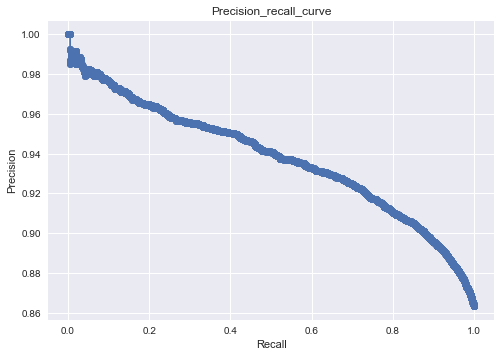

In [117]:
# F1-score, auc, precision_recall_curve
from sklearn.metrics import f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
f1 = f1_score(y_test, pred)
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob[:,1])
auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, pred_prob[:,1])
print("Average precision score:", avg_precision)
print("F1_score:", f1)
print("Auc score:", auc)
plot_precision_recall_curve(recall, precision)

In [118]:
# Accuracy on train data
train_acc_avgw2v_random = lr_model.score(std_X_train, y_train)
print("Train accuracy", train_acc_avgw2v_random)

Train accuracy 0.7983857142857143


In [119]:
test_acc_avgw2v_random = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' % (optimal_lambda_avgw2v_random, test_acc_avgw2v_random))


The accuracy of the logistic regression for c = 3.333186 is 86.32%


In [120]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[    0,  4103],
       [    1, 25896]], dtype=int64)

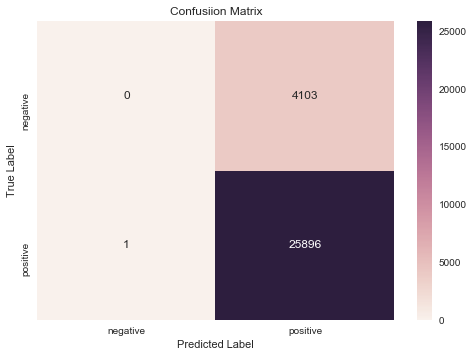

In [121]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [122]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4103
           1       0.86      1.00      0.93     25897

   micro avg       0.86      0.86      0.86     30000
   macro avg       0.43      0.50      0.46     30000
weighted avg       0.75      0.86      0.80     30000



In [123]:
# Tried different value of c and finding features weight
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C)
C_param = [10, 1, 0.1]

for c in C_param:
    clf = LogisticRegression(penalty = 'l2', C = c, class_weight = "balanced")
    clf.fit(std_X_train, y_train)
    print('\nC value:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy: %0.3f%%' %(clf.score(std_X_train, y_train) * 100))
    print('Test accuracy: %0.3f%%' %(clf.score(std_x_test, y_test) * 100))
    print("Number of non-zero element: ",np.count_nonzero(clf.coef_))


C value: 10
Coefficient of each feature: [[ 0.03975905 -0.09590719  0.35989163  0.72908844  0.64388973 -0.09121991
  -0.9023972   0.53688893  0.73078622  0.89906832 -0.08646094 -0.11972015
  -0.33271437  0.56159674 -0.26642071  0.87312717 -0.36335715 -0.37834897
   0.09540617  0.78437738  0.11460528  0.38608337  0.08405536  0.06209608
   1.14820815  0.06109586 -0.542622   -1.32974097  0.48510795  0.41917413
   0.25941287 -0.33130008 -0.04003611  0.9313817  -0.05251753  0.61314233
  -0.77189294 -0.49945089 -0.893888   -1.22729451  0.03424499 -0.60886939
  -0.67647563  0.0559067   0.13721738  0.0096642  -0.12540648  0.27848162
  -0.13576594  0.44520065]]
Training accuracy: 79.836%
Test accuracy: 86.320%
Number of non-zero element:  50

C value: 1
Coefficient of each feature: [[ 0.04783758 -0.10276289  0.33778686  0.67760986  0.57237603 -0.07921165
  -0.83498198  0.55217942  0.63632497  0.89875763 -0.08834517 -0.11218103
  -0.25845046  0.4815474  -0.2630961   0.78845919 -0.34443412 -0.33

## Checking for multicollinearity using pertubation test

In [124]:
clf = LogisticRegression(penalty = 'l2', C = optimal_lambda_avgw2v_random, class_weight = "balanced")
clf.fit(std_X_train, y_train)
y_pred = clf.predict(std_x_test)
print("Accuracy score: %0.2f%%" %(accuracy_score(y_test, y_pred) * 100))
print(np.count_nonzero(clf.coef_))

Accuracy score: 86.32%
50


In [125]:
std_X_train.shape

(70000, 50)

In [126]:
np.count_nonzero(clf.coef_)

50

In [127]:
from scipy.sparse import find

# Before adding noise in data
cf = clf.coef_[0]
w_coef1 = cf[np.nonzero(cf)]
print(w_coef1[:50])

[ 0.04175409 -0.09758572  0.35438145  0.71629247  0.62612245 -0.08822091
 -0.88560311  0.54068596  0.70729962  0.89897384 -0.08692032 -0.11784467
 -0.31425953  0.54171487 -0.26559801  0.8520731  -0.35864598 -0.36746792
  0.08900521  0.7495532   0.10918877  0.37247727  0.08098621  0.06652803
  1.12869842  0.06647968 -0.53189024 -1.29346091  0.47335561  0.38938885
  0.25485503 -0.3217782  -0.03840089  0.90058936 -0.03978172  0.60959582
 -0.74577745 -0.51322471 -0.8631214  -1.20122341  0.03251758 -0.60402908
 -0.65608871  0.04463329  0.12852276  0.01255453 -0.12761347  0.26722562
 -0.13160672  0.42471046]


In [128]:
# Generate random normal variable as a noise 
std_X_train_pert = std_X_train
noise = np.random.normal(0, 0.001, size = (std_X_train_pert[np.nonzero(std_X_train_pert)].size,))
#print(noise.shape)
np.nonzero(std_X_train_pert)
std_X_train_pert[np.nonzero(std_X_train_pert)] = noise + std_X_train_pert[np.nonzero(std_X_train_pert)]
std_X_train_pert.shape

(70000, 50)

In [129]:
std_X_train_pert.shape

(70000, 50)

In [130]:
clf = LogisticRegression(penalty = 'l2', C = optimal_lambda_avgw2v_random, class_weight = "balanced")
clf.fit(std_X_train_pert, y_train)
y_pred = clf.predict(std_x_test)
print("Accuracy score: %0.2f%%" %(accuracy_score(y_test, y_pred) * 100))
print(np.count_nonzero(clf.coef_))

Accuracy score: 86.32%
50


In [131]:
cf = clf.coef_[0]
w_coef2 = cf[np.nonzero(cf)]
print(w_coef2[:50])

[ 0.04175496 -0.09751782  0.35459062  0.71659825  0.62668325 -0.08832716
 -0.8862377   0.54072445  0.70787276  0.89878991 -0.08697709 -0.11781463
 -0.31481862  0.54215807 -0.26575125  0.8528148  -0.35885065 -0.3678493
  0.08927401  0.75057997  0.10935904  0.37287108  0.08112748  0.06624255
  1.12932859  0.06647624 -0.53225697 -1.29449484  0.4736887   0.39033984
  0.25512032 -0.3221657  -0.03849367  0.90153136 -0.04024499  0.60971881
 -0.74648091 -0.51277534 -0.86405135 -1.20201559  0.03263782 -0.60432811
 -0.65667993  0.04499669  0.12881498  0.01239539 -0.1274254   0.26745978
 -0.13171124  0.42534591]


In [132]:
# Calculate %increase 
cnt = 0
for w1, w2 in zip(w_coef1, w_coef2):
    inc = (abs(w1 - w2)/abs(w2)) * 100
    if inc > 40:
        cnt += 1
print("No of weights that changes more than 40% is:", cnt)

No of weights that changes more than 40% is: 0


**Observations**
1. When used accuracy as performance measure we get train accuracy is low whereas test accuracy is high. It could so happen that model is underfitting.
2. Generalizaion error for this model is high and does not works well for both grid search and random search. 
3. Using pertubation technique we found that there is no multicollinearity.
4. As we know w2v can give you 50,100,150,200 etc dimension vector for a given word, using avg w2v we get word vector for sentences. So, As we can not compare which word has highest value ,we can not get which feature is importance.

# TFIDF Word2Vec

In [133]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = [] # the tfidf-w2v for each sentence/review is stored in this list
row=0
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_trn[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [134]:
len(tfidf_sent_vectors)

70000

In [135]:
X_train = tfidf_sent_vectors

In [136]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_test.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = x_tst[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [137]:
len(tfidf_sent_vectors_test)

30000

In [138]:
x_test = tfidf_sent_vectors_test

In [147]:
X_train = np.nan_to_num(X_train)

In [150]:
# Standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)

In [151]:
std_X_train.shape

(70000, 50)

In [152]:
x_test = np.nan_to_num(x_test)

In [153]:
scaler = StandardScaler(with_mean = False)
std_x_test = scaler.fit_transform(x_test)

In [154]:
std_x_test.shape

(30000, 50)


**********GridSearchCV**********


Optimal C: 0.01

Best penalty: l2


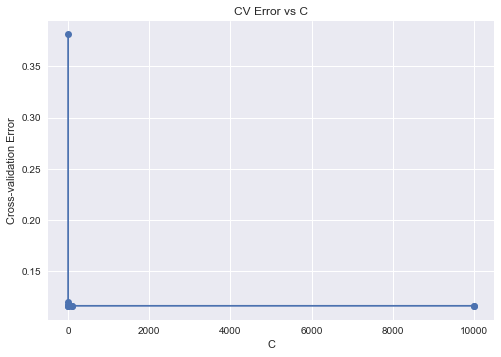

0.01

In [155]:
# To choose optimal_alpha using nested cross validation
optimal_lambda_tfidfw2v_grid = lr_grid_plot(std_X_train, y_train)
optimal_lambda_tfidfw2v_grid

In [156]:
# instantiate learning model 
lr_model =  LogisticRegression(penalty = 'l2', C = optimal_lambda_tfidfw2v_grid, class_weight = "balanced")
# fitting the model
lr_model.fit(std_X_train, y_train)
# predict the response
pred = lr_model.predict(std_x_test)
# predict probablistic response
pred_prob = lr_model.predict_proba(std_x_test)

Average precision score: 0.9440371854956844
F1_score: 0.920242459973838
Auc score: 0.9440336196904263


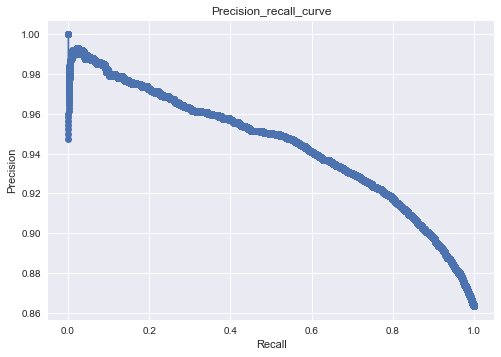

In [164]:
# F1-score, auc, precision_recall_curve
from sklearn.metrics import f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
f1 = f1_score(y_test, pred)
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob[:,1])
auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, pred_prob[:,1])
print("Average precision score:", avg_precision)
print("F1_score:", f1)
print("Auc score:",auc)
plot_precision_recall_curve(recall, precision)

In [165]:
# Accuracy on train data
train_acc_tfidfw2v_grid = lr_model.score(std_X_train, y_train)
print("Train accuracy", train_acc_tfidfw2v_grid)

Train accuracy 0.7316571428571429


In [166]:
test_acc_tfidfw2v_grid = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the logistic regression for c = %0.3f is %f%%' % (optimal_lambda_tfidfw2v_grid, test_acc_tfidfw2v_grid))


The accuracy of the logistic regression for c = 0.010 is 85.570000%


In [167]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[  697,  3406],
       [  923, 24974]], dtype=int64)

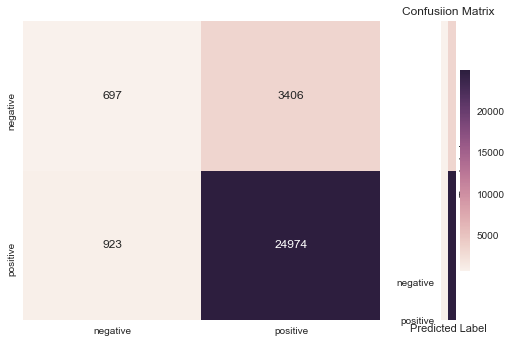

In [169]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [170]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.43      0.17      0.24      4103
           1       0.88      0.96      0.92     25897

   micro avg       0.86      0.86      0.86     30000
   macro avg       0.66      0.57      0.58     30000
weighted avg       0.82      0.86      0.83     30000





**********RandomizedSearchCV**********


Optimal C: 3.1052037226141174

Best penalty: l1


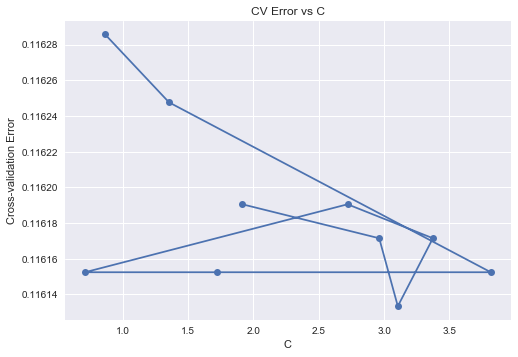

3.1052037226141174

In [171]:
optimal_lambda_tfidfw2v_random = lr_random_plot(std_X_train, y_train)
optimal_lambda_tfidfw2v_random

In [172]:
# instantiate learning model 
lr_model =  LogisticRegression(penalty = 'l1', C = optimal_lambda_tfidfw2v_random, class_weight = "balanced")
# fitting the model
lr_model.fit(std_X_train, y_train)
# predict the response
pred = lr_model.predict(std_x_test)
# predict probablistic response
pred_prob = lr_model.predict_proba(std_x_test)

Average precision score: 0.9403896419288639
F1_score: 0.926059123930087
Auc score: 0.9403860106315642


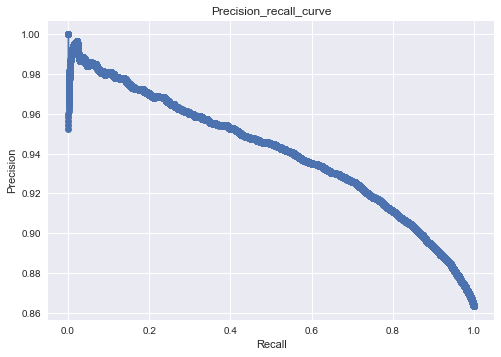

In [174]:
# F1-score, auc, precision_recall_curve
from sklearn.metrics import f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
f1 = f1_score(y_test, pred)
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob[:,1])
auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, pred_prob[:,1])
print("Average precision score:", avg_precision)
print("F1_score:", f1)
print("Auc score:",auc)
plot_precision_recall_curve(recall, precision)

In [175]:
# Accuracy on train data
train_acc_tfidfw2v_random = lr_model.score(std_X_train, y_train)
print("Train accuracy", train_acc_tfidfw2v_random)

Train accuracy 0.7292


In [176]:
test_acc_tfidfw2v_random = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' % (optimal_lambda_tfidfw2v_random, test_acc_tfidfw2v_random))


The accuracy of the logistic regression for c = 3.105204 is 86.29%


In [177]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[  138,  3965],
       [  147, 25750]], dtype=int64)

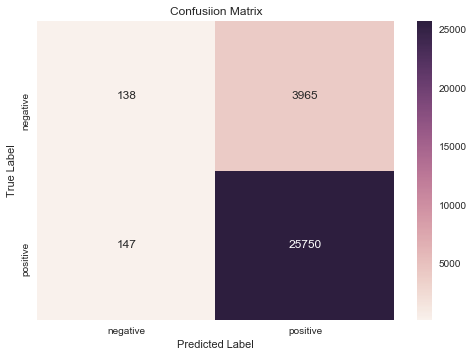

In [178]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [179]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.48      0.03      0.06      4103
           1       0.87      0.99      0.93     25897

   micro avg       0.86      0.86      0.86     30000
   macro avg       0.68      0.51      0.49     30000
weighted avg       0.81      0.86      0.81     30000



In [180]:
# Tried different value of c and finding features weight
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C)
C_param = [10, 1, 0.1]

for c in C_param:
    clf = LogisticRegression(penalty='l1', C = c)
    clf.fit(X_train, y_train)
    print('\nC value:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy: %0.3f%%' %(clf.score(std_X_train, y_train) * 100))
    print('Test accuracy: %0.3f%%' %(clf.score(std_x_test, y_test) * 100))
    print("Number of non-zero element: ",np.count_nonzero(clf.coef_))


C value: 10
Coefficient of each feature: [[-0.08078395 -0.15312764  0.30609337  0.75460852  0.35038517  0.02226248
  -0.51875463  0.50497443  0.2997992   0.57905648 -0.05519565 -0.12383712
  -0.09245356  0.54985655 -0.23304295  0.71647798 -0.72565228 -0.11711424
   0.23995611  0.41193655  0.00298065  0.41555562 -0.1756367  -0.12277071
   0.75615105  0.37168642 -0.54256688 -0.83584879  0.40555371  0.15468393
   0.02066725 -0.39348564 -0.41652301  0.63511572  0.16875294  0.31399705
  -0.5748793  -0.53384756 -0.07274192 -0.74184894  0.02348744 -0.34275787
  -0.32964473  0.03531761  0.09517957  0.02959366 -0.17198364  0.09823722
  -0.15915811  0.23186323]]
Training accuracy: 88.640%
Test accuracy: 86.323%
Number of non-zero element:  50

C value: 1
Coefficient of each feature: [[-0.07493706 -0.15843602  0.30049515  0.7331963   0.32576316  0.02612826
  -0.48595342  0.5132601   0.26909086  0.57773457 -0.0589813  -0.1182941
  -0.06688607  0.52097666 -0.22761179  0.68699714 -0.71808737 -0.098

## Checking for multicollinearity using pertubation test

In [181]:
clf = LogisticRegression(penalty='l1', C = optimal_lambda_tfidfw2v_random)
clf.fit(std_X_train, y_train)
y_pred = clf.predict(std_x_test)
print("Accuracy score: %0.2f%%" %(accuracy_score(y_test, y_pred) * 100))
print(np.count_nonzero(clf.coef_))

Accuracy score: 86.32%
50


In [182]:
std_X_train.shape

(70000, 50)

In [183]:
np.count_nonzero(clf.coef_)

50

In [184]:
from scipy.sparse import find

# Before adding noise in data
cf = clf.coef_[0]
w_coef1 = cf[np.nonzero(cf)]
print(w_coef1[:50])

[-0.04796088 -0.10614419  0.21895483  0.46495007  0.21899935  0.01393453
 -0.30668273  0.32939427  0.17405134  0.39786838 -0.03820991 -0.09833356
 -0.08005614  0.31422891 -0.14979487  0.5142251  -0.47269613 -0.07920646
  0.16074862  0.24630429  0.00132531  0.25939239 -0.11201208 -0.08392959
  0.54236281  0.22007347 -0.42000632 -0.58653199  0.29643264  0.11893537
  0.01320982 -0.25858581 -0.37882378  0.39139832  0.15363631  0.2248318
 -0.39205912 -0.37542417 -0.05420918 -0.46173828  0.01756934 -0.27171288
 -0.21157901  0.02547252  0.07289098  0.02349362 -0.12505278  0.06984525
 -0.09265388  0.16248885]


In [185]:
# Generate random normal variable as a noise 
std_X_train_pert = std_X_train
noise = np.random.normal(0, 0.001, size = (std_X_train_pert[np.nonzero(std_X_train_pert)].size,))
np.nonzero(std_X_train_pert)
std_X_train_pert[np.nonzero(std_X_train_pert)] = noise + std_X_train_pert[np.nonzero(std_X_train_pert)]
std_X_train_pert.shape

(70000, 50)

In [186]:
# Generate random normal variable as a noise 
std_X_train_pert = std_X_train
noise = np.random.normal(0, 0.001, size = (std_X_train_pert[np.nonzero(std_X_train_pert)].size,))
np.nonzero(std_X_train_pert)
std_X_train_pert[np.nonzero(std_X_train_pert)] = noise + std_X_train_pert[np.nonzero(std_X_train_pert)]
std_X_train_pert.shape

(70000, 50)

In [187]:
std_X_train_pert.shape

(70000, 50)

In [188]:
clf = LogisticRegression(penalty='l1', C = optimal_lambda_tfidfw2v_random)
clf.fit(std_X_train_pert, y_train)
y_pred = clf.predict(x_test)
print("Accuracy score: %0.2f%%" %(accuracy_score(y_test, y_pred) * 100))
print(np.count_nonzero(clf.coef_))

Accuracy score: 86.32%
50


In [189]:
cf = clf.coef_[0]
w_coef1 = cf[np.nonzero(cf)]
print(w_coef2[:50])

[ 0.04175496 -0.09751782  0.35459062  0.71659825  0.62668325 -0.08832716
 -0.8862377   0.54072445  0.70787276  0.89878991 -0.08697709 -0.11781463
 -0.31481862  0.54215807 -0.26575125  0.8528148  -0.35885065 -0.3678493
  0.08927401  0.75057997  0.10935904  0.37287108  0.08112748  0.06624255
  1.12932859  0.06647624 -0.53225697 -1.29449484  0.4736887   0.39033984
  0.25512032 -0.3221657  -0.03849367  0.90153136 -0.04024499  0.60971881
 -0.74648091 -0.51277534 -0.86405135 -1.20201559  0.03263782 -0.60432811
 -0.65667993  0.04499669  0.12881498  0.01239539 -0.1274254   0.26745978
 -0.13171124  0.42534591]


In [190]:
# Calculate %increase 
cnt = 0
for w1, w2 in zip(w_coef1, w_coef2):
    inc = (abs(w1 - w2)/abs(w1)) * 100  
    if inc > 40:
        cnt += 1
print("No of weights that changes more than 40% is:", cnt)

No of weights that changes more than 40% is: 43


**Observations**
1. model is biased towards +ve class. 
2. features are multicollinear because 43 feature weights changes more than 40%.

**Conclusions**
1. we reduced training error and balance error between both training and testing. Although, cross-validataion do not completly remove underfitting or overfitting.
2. bow and tfidf is working well whereas avg word2vec and tfidf w2v is like dumb model.

In [199]:
# model performence table using grid search
import itable
models = pd.DataFrame({'Model': ['LogisticRegression with Bow', "LogisticRegression with TFIDF", "LogisticRegression with avgw2v", "LogisticRegression with TFIDFW2V"], 'Hyper Parameter(lambda)': [optimal_lambda_bow_grid, optimal_lambda_tfidf_grid, optimal_lambda_avgw2v_grid, optimal_lambda_tfidfw2v_grid], 'Train Error': [1-train_acc_bow_grid, 1-train_acc_tfidf_grid, 1-train_acc_avgw2v_grid, 1-train_acc_tfidfw2v_grid], 'Test Error': [100-test_acc_bow_grid, 100-test_acc_tfidf_grid, 100-test_acc_avgw2v_grid, 100-test_acc_tfidfw2v_grid], 'Accuracy': [test_acc_bow_grid, test_acc_tfidf_grid, test_acc_avgw2v_grid, test_acc_tfidfw2v_grid]}, columns = ["Model", "Hyper Parameter(lambda)", "Train Error", "Test Error", "Accuracy"]).sort_values(by='Accuracy', ascending=False)
itable.PrettyTable(models, tstyle = itable.TableStyle(theme = "theme1"), center = True, header_row = True)

,Model,Hyper Parameter(lambda),Train Error,Test Error,Accuracy
1,LogisticRegression with TFIDF,0.01,0.012299999999999978,8.329999999999998,91.67
0,LogisticRegression with Bow,0.01,0.02898571428571428,11.656666666666666,88.34333333333333
2,LogisticRegression with avgw2v,100.0,0.2017428571428571,13.680000000000007,86.32
3,LogisticRegression with TFIDFW2V,0.01,0.2683428571428571,14.429999999999993,85.57000000000001


In [196]:
# model performence table using random search
models = pd.DataFrame({'Model': ['LogisticRegression with Bow', "LogisticRegression with TFIDF", "LogisticRegression with avgw2v", "LogisticRegression with TFIDFW2V"], 'Hyper Parameter(lambda)': [optimal_lambda_bow_random, optimal_lambda_tfidf_random, optimal_lambda_avgw2v_random, optimal_lambda_tfidfw2v_random ], 'Train Error': [1-train_acc_bow_random, 1-train_acc_tfidf_random, 1-train_acc_avgw2v_random, 1-train_acc_tfidfw2v_random], 'Test Error': [100-test_acc_bow_random, 100-test_acc_tfidf_random, 100-test_acc_avgw2v_random, 100-test_acc_tfidfw2v_random], 'Accuracy': [test_acc_bow_random, test_acc_tfidf_random, test_acc_avgw2v_random, test_acc_tfidfw2v_random]}, columns = ["Model", "Hyper Parameter(lambda)", "Train Error", "Test Error", "Accuracy"]).sort_values(by = "Accuracy", ascending = False)
itable.PrettyTable(models, tstyle = itable.TableStyle(theme = "theme1"), center = True, header_row = True)

,Model,Hyper Parameter(lambda),Train Error,Test Error,Accuracy
1,LogisticRegression with TFIDF,0.23860360422442373,1.4285714285744433e-05,8.840000000000003,91.16
0,LogisticRegression with Bow,0.8942617375947473,0.021342857142857108,13.036666666666662,86.96333333333334
2,LogisticRegression with avgw2v,3.3331862167206348,0.20161428571428575,13.680000000000007,86.32
3,LogisticRegression with TFIDFW2V,3.1052037226141174,0.27080000000000004,13.706666666666663,86.29333333333334
